# Talking Data

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import time
import random
import tarfile
import zipfile
#import StringIO
from IPython.display import display, Image

from sklearn.preprocessing import LabelEncoder
#from scipy import ndimage
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans,MeanShift
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import linear_model, decomposition, datasets, ensemble
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score


datadir="./data/TalkingData/"

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

### some function def

In [2]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std

In [3]:
   
def runPredict(clf,data, display=True):
    index=random.randrange(len(data))
    y_pred = clf.predict_proba(data[index].reshape(1, -1))[0]
    if display==True:
        print "for:",data[index], "\nprediction:",y_pred
    return y_pred

def train_classifier(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    return end - start
    #print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    
# Predict on training set and compute F1 score
def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target, y_pred,average='micro'),end - start #(None, 'micro', 'macro', 'weighted', 'samples')

# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):

    timeTrain=train_classifier(clf, X_train, y_train)
    predict_train,trainDelta=predict_labels(clf, X_train, y_train)
    predict_test,testDelta=predict_labels(clf, X_test, y_test)
    return predict_test,testDelta,predict_train,trainDelta,timeTrain # let's return the scores, so we can use them for comparisons

#for each data set size run and plot a train/test
def runTests(test_sizes, train_dataset,train_labels,test_dataset,test_labels, clf="", usePCA=False):
    test_f1=[]
    train_f1=[]

    for test_size in test_sizes:
        # Set up the train set for the test size
        X_train=train_dataset[:test_size]
        y_train=train_labels[:test_size]
        # Same for test
        X_test=test_dataset[-test_size:]
        y_test=test_labels[-test_size:]

 
        if clf == "":
            clf=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,  max_iter=200,C=.1, n_jobs = -1)
            
        if usePCA ==True:
            pca=decomposition.PCA(n_components = 14*14)
            clf=Pipeline(steps=[('pca', pca), ('classifier', clf )]) # set up the clf as a pipeline ])
        # Fit model to training data
        test,testDelta,train,trainDelta,timeTrain = train_predict(clf, X_train, y_train, X_test, y_test)
        test_f1.append(test)
        train_f1.append(train)
        print ("------------------------------------------")
        print ("Training set size: {},".format(len(X_train)),"Train time (secs): {:.3f}".format(timeTrain))
        print ("F1 score for training set: {},".format(train),"Prediction time (secs): {:.3f}".format(trainDelta))
        print ("F1 score for test set: {},".format(test),"Prediction time (secs): {:.3f}".format(testDelta))

    
    print ("\n",clf)
    print("Test F1:{}".format(test_f1))
    display("Train F1:{}".format(train_f1))
    plt.plot(test_f1,label="Test F1")
    plt.plot(train_f1,label="Train F1")
    plt.legend(loc=2)
    plt.title("F1 Score per run")
    plt.show()
    
    return clf    

## Import data

In [8]:
# load up the data!
app_events = loadData(datadir,'app_events.csv.zip')
app_labels = loadData(datadir,'app_labels.csv.zip')
label_categories = loadData(datadir,'label_categories.csv.zip')

events = loadData(datadir,'events.csv.zip')
events['timestamp']=pd.to_datetime(events['timestamp'])


phone_brand_device_model = loadData(datadir,'phone_brand_device_model.csv.zip')
phone_brand_device_model.drop_duplicates('device_id',keep='first', inplace=True)

gender_age_train = loadData(datadir,'gender_age_train.csv.zip')
#gender_age_test = loadData(datadir,'gender_age_test.csv.zip')




loading: ./data/TalkingData/app_events.csv.zip
Dataset has 32473067 samples with 4 features each.
loading: ./data/TalkingData/app_labels.csv.zip
Dataset has 459943 samples with 2 features each.
loading: ./data/TalkingData/label_categories.csv.zip
Dataset has 930 samples with 2 features each.
loading: ./data/TalkingData/events.csv.zip
Dataset has 3252950 samples with 5 features each.
loading: ./data/TalkingData/phone_brand_device_model.csv.zip
Dataset has 187245 samples with 3 features each.
loading: ./data/TalkingData/gender_age_train.csv.zip
Dataset has 74645 samples with 4 features each.


### Create a location feature, and look at it

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 5 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 124.1 MB


None

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 2 columns):
longitude    float64
latitude     float64
dtypes: float64(2)
memory usage: 49.6 MB


None

,longitude,latitude
0,121.38,31.24
1,103.65,30.97
2,106.60,29.70
3,104.27,23.28


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


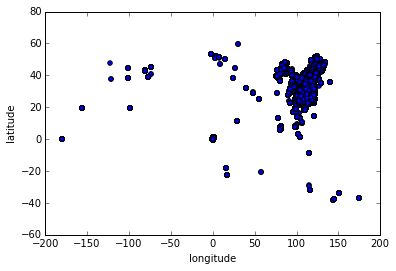

In [9]:
#cluster the locations in the event
display(events.info())
display(events.head(4))

locations=events.drop(['event_id','device_id','timestamp'],1)
display(locations.info())
display(locations.head(4))

locations.plot(kind='scatter',x='longitude',y='latitude')
plt.show()
plt.close()

In [15]:
# get many cluster centers of the data, for a large number of clusters
def kmeansPlusmeanshift(data):
    startingClusterSize=int(len(data)*.0005)
    print "kmeans.... for {} clusters".format(startingClusterSize)
    k_means =KMeans(n_clusters=startingClusterSize,n_jobs=10)
    k_means.fit(data.sample(frac=0.2).values)
    clusters=k_means.cluster_centers_
    print clusters[:15]

    #use the cluster centers of the guessed clusters to get an estimate of actual numbers of clusters. doing this for speed increase!
    print "\nmeanshift..."
    meanshift=MeanShift(n_jobs=10)
    meanshift.fit(clusters)
    newcenters=meanshift.cluster_centers_
    print newcenters[:15], "\nnum of clusters from meanshift:",len(newcenters)

    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=len(newcenters)+1,n_jobs=10)
    final_clusters=k_means.fit_predict(data.values)
    return final_clusters
    
# it's nice to not repeat this calculation--it's the slowest part of the job! note that it should be recalced if events changes
final_clusters_fname="final_clusters.csv"
if os.path.isfile(final_clusters_fname):    
    final_clusters=np.loadtxt(final_clusters_fname,  delimiter=",")
    print "sample clusters after kmeans:\n ",final_clusters[:15]

else:
    print "recalculating clusters..."
    final_clusters=kmeansPlusmeanshift(locations)
    print "sample clusters after kmeans:\n ",final_clusters[:15]
    # save the above for easier reload!
    np.savetxt(final_clusters_fname, final_clusters, delimiter=",")
    

sample clusters after kmeans:
  [ 10.  11.  11.   3.  13.   1.   8.   9.   1.   0.  16.  16.  15.  13.  10.]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 6 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
location     float64
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 148.9 MB


None

,event_id,device_id,timestamp,longitude,latitude,location
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,10.0
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,11.0
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,11.0
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,3.0
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,13.0
5,6,1476664663289716375,2016-05-01 00:27:21,0.00,0.00,1.0
6,7,5990807147117726237,2016-05-01 00:15:13,113.73,23.00,8.0
7,8,1782450055857303792,2016-05-01 00:15:35,113.94,34.70,9.0
8,9,-2073340001552902943,2016-05-01 00:15:33,0.00,0.00,1.0
9,10,-8195816569128397698,2016-05-01 00:41:31,119.34,26.04,0.0


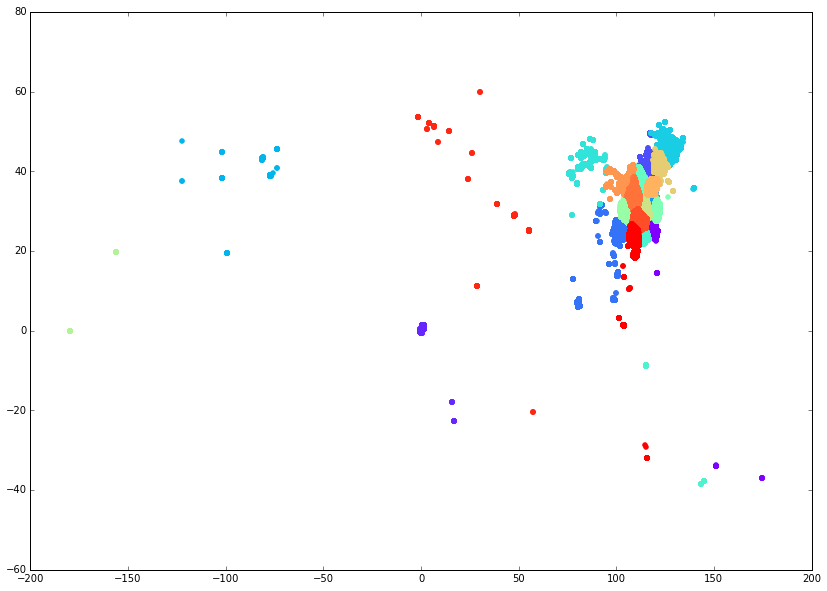

In [16]:
events['location']=final_clusters
display(events.info())
display(events.head(10))

numlocationclusters=len(np.unique(final_clusters))

plt.figure(figsize=(14,10))
colors = cm.rainbow(np.linspace(0, 1, numlocationclusters))

for cluster in range(numlocationclusters):
    plt.scatter(events[events['location']==cluster]['longitude'],
             events[events['location']==cluster]['latitude'],
             color=colors[cluster])
             #color=colors[locations[locations['cluster']==cluster]['cluster']])
        
plt.show()
plt.close()

### Create a time feature

In [17]:

#times=events['timestamp']
display(events.info())
display(events.head(5))

events_timeindex=events.set_index('timestamp')
#display(events_timeindex.info())
#display(events_timeindex.head(5))

events["hour"] = events_timeindex.index.hour
events["day"] = events_timeindex.index.day
print "unique days",events["day"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 6 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
location     float64
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 148.9 MB


None

,event_id,device_id,timestamp,longitude,latitude,location
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,10.0
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,11.0
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,11.0
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,3.0
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,13.0


unique days [ 1 30  2  3  4  5  6  7  8]


### take the new created features into a new setting, leaving the original as it was.

In [18]:
events_featured=events.drop(["timestamp",'longitude','latitude'],1) 
events.drop(["location",'hour','day'],1) 

display(events.sample(frac=0.2).head(5))
display(events_featured.sample(frac=0.2).head(5))
display(events_featured.info())


,event_id,device_id,timestamp,longitude,latitude,location,hour,day
1498299,1498300,7236393560264072287,2016-05-02 09:08:26,0.00,0.00,1.0,9,2
210643,210644,4481624019487198538,2016-05-01 21:07:08,0.00,0.00,1.0,21,1
1564176,1564177,-1021066173965795999,2016-05-02 21:45:39,122.28,40.68,14.0,21,2
711476,711477,6583000181979937577,2016-05-07 15:29:46,0.00,0.00,1.0,15,7
802102,802103,8857250467436463503,2016-05-05 20:59:48,1.00,1.00,1.0,20,5


,event_id,device_id,location,hour,day
2398604,2398605,-2241630667689903982,9.0,13,3
2674308,2674309,-7489673451535774154,6.0,17,7
3198604,3198605,-2820717098050846969,1.0,12,4
1456133,1456134,6269247678257831921,1.0,16,3
1604572,1604573,-5775702190687783340,1.0,10,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 5 columns):
event_id     int64
device_id    int64
location     float64
hour         int32
day          int32
dtypes: float64(1), int32(2), int64(2)
memory usage: 99.3 MB


None

In [19]:
# from https://www.kaggle.com/agavranis/talkingdata-mobile-user-demographics/bag-of-apps-keras-11-08-16-no-val/code
# Data - Events data
# Bag of apps
print("# Read app events")
#app_events = pd.read_csv(os.path.join(datadir,'app_events.csv'), dtype={'device_id' : np.str})
display(app_events.head(5))
display(app_events.info())
#print(rstr(app_events))




# Read app events


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
event_id        int64
app_id          int64
is_installed    int64
is_active       int64
dtypes: int64(4)
memory usage: 991.0 MB


None

In [20]:
# store all the unique app ids
app_id_unique= app_events.app_id.unique()
print len(app_id_unique)
display(app_id_unique[:15])


19237


array([ 5927333115845830913, -5720078949152207372, -1633887856876571208,
        -653184325010919369,  8693964245073640147,  4775896950989639373,
       -8022267440849930066,  9112463267739110219, -3725672010020973973,
        7167114343576723123,   487766649788038994,  7460082553072507347,
         628020936226491308,   701031210314548601, -1758857579862594461])

In [22]:
# remove duplicates(app_id)
app_events= app_events.groupby("event_id")["app_id"].apply(
        lambda x: list(s for s in x))
        #lambda x: list(np.where(app_id_unique==s) for s in x))
app_events.head(5)

KeyError: 'event_id'

In [23]:
print("# Read Events")
#events = pd.read_csv(os.path.join(datadir,'events.csv'), dtype={'device_id': np.str})
display(events_featured.head(5))
events_featured["app_id"] = events_featured["event_id"].map(app_events)
events_featured = events_featured.dropna()

events_featured = events_featured[["device_id", "app_id", 'event_id','location', 'hour','day']]
display(events_featured.info())
display(events_featured.head(4))
# 1Gb reduced to 34 Mbevents_featured.head(5)

# Read Events


,event_id,device_id,location,hour,day
0,1,29182687948017175,10.0,0,1
1,2,-6401643145415154744,11.0,0,1
2,3,-4833982096941402721,11.0,0,1
3,4,-6815121365017318426,3.0,0,1
4,5,-5373797595892518570,13.0,0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488096 entries, 1 to 3252947
Data columns (total 6 columns):
device_id    1488096 non-null int64
app_id       1488096 non-null object
event_id     1488096 non-null int64
location     1488096 non-null float64
hour         1488096 non-null int32
day          1488096 non-null int32
dtypes: float64(1), int32(2), int64(2), object(1)
memory usage: 68.1+ MB


None

,device_id,app_id,event_id,location,hour,day
1,-6401643145415154744,"[5927333115845830913, -5720078949152207372, -1...",2,11.0,0,1
5,1476664663289716375,"[-7377004479023402858, 6284164581582112235, 59...",6,1.0,0,1
6,5990807147117726237,"[-5025470775416984603, -5368809411346728624, 2...",7,8.0,0,1
8,-2073340001552902943,"[-7377004479023402858, -5025470775416984603, -...",9,1.0,0,1


### vectorize the apps:

In [24]:
print app_id_unique[:3]

element=-1633887856876571208

itemindex = np.where(app_id_unique==element)
print "element:",element,"index is:",itemindex,"contains:", app_id_unique[itemindex]




[ 5927333115845830913 -5720078949152207372 -1633887856876571208]
element: -1633887856876571208 index is: (array([2]),) contains: [-1633887856876571208]


In [25]:


    
# it's nice to not repeat this calculation--it's the slowest part of the job! note that it should be recalced if events changes
events_vectorized_appID_fname="events_vectorized_appID.csv"
if os.path.isfile(events_vectorized_appID_fname):    
    events_vectorized_appID=loadData("./",events_vectorized_appID_fname)
    display(events_vectorized_appID.info())
    display(events_vectorized_appID.head(4))

else:
    print "recalculating clusters..."
    events_vectorized_appID=events_featured.app_id.apply(lambda x: list(np.where(app_id_unique==s)[0][0] for s in x))
    display(events_vectorized_appID.info())
    display(events_vectorized_appID.head(4))
    # save the above for easier reload!
    writeData(events_vectorized_appID,events_vectorized_appID_fname)
    

loading: ./events_vectorized_appID.csv
Dataset has 1488095 samples with 1 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488095 entries, 0 to 1488094
Data columns (total 1 columns):
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]    1488095 non-null object
dtypes: object(1)
memory usage: 11.4+ MB


None

,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]"
0,"[19, 20, 0, 21, 22, 23, 24, 25, 4, 26, 27, 28,..."
1,"[53, 54, 55, 56, 57, 3, 58, 59, 60, 4, 61, 62,..."
2,"[19, 53, 85, 86, 0, 56, 87, 4, 88, 89, 65, 90,..."
3,"[19, 107, 2, 108, 109, 60, 110, 111, 64, 112, ..."


In [26]:
events_featured_Appid_orig=events_featured['app_id']

events_featured['app_id']=events_vectorized_appID

display(events_featured.info())
display(events_featured.head(4))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488096 entries, 1 to 3252947
Data columns (total 6 columns):
device_id    1488096 non-null int64
app_id       680651 non-null object
event_id     1488096 non-null int64
location     1488096 non-null float64
hour         1488096 non-null int32
day          1488096 non-null int32
dtypes: float64(1), int32(2), int64(2), object(1)
memory usage: 68.1+ MB


None

,device_id,app_id,event_id,location,hour,day
1,-6401643145415154744,"[53, 54, 55, 56, 57, 3, 58, 59, 60, 4, 61, 62,...",2,11.0,0,1
5,1476664663289716375,"[138, 139, 140, 141, 142, 143, 144, 127, 145, ...",6,1.0,0,1
6,5990807147117726237,"[165, 166, 19, 167, 54, 168, 0, 169, 170, 59, ...",7,8.0,0,1
8,-2073340001552902943,"[193, 0, 126, 194, 195, 196, 4, 197, 198, 89, ...",9,1.0,0,1


In [27]:

#events_featured['app_id']=events_featured_Appid_orig

#display(events_featured.info())
display(events_featured.head(4))

,device_id,app_id,event_id,location,hour,day
1,-6401643145415154744,"[53, 54, 55, 56, 57, 3, 58, 59, 60, 4, 61, 62,...",2,11.0,0,1
5,1476664663289716375,"[138, 139, 140, 141, 142, 143, 144, 127, 145, ...",6,1.0,0,1
6,5990807147117726237,"[165, 166, 19, 167, 54, 168, 0, 169, 170, 59, ...",7,8.0,0,1
8,-2073340001552902943,"[193, 0, 126, 194, 195, 196, 4, 197, 198, 89, ...",9,1.0,0,1


In [28]:
del app_events

### start merging with the training data

In [29]:
# just events related to devices in training:
display(gender_age_train.info())
display(gender_age_train.head(4))

print ("merging: events_featured")
train_events = gender_age_train.merge(events_featured, how='left', on='device_id')
train_events.drop(['gender','age'],1, inplace=True)
display(train_events.info())
display(train_events.head(4))

print ("merging: phone_brand_device_model")
train_events = train_events.merge(phone_brand_device_model, how='left', on='device_id')
display(train_events.info())
display(train_events.head(4))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74645 entries, 0 to 74644
Data columns (total 4 columns):
device_id    74645 non-null int64
gender       74645 non-null object
age          74645 non-null int64
group        74645 non-null object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


None

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31


merging: events_featured
<class 'pandas.core.frame.DataFrame'>
Int64Index: 607730 entries, 0 to 607729
Data columns (total 7 columns):
device_id    607730 non-null int64
group        607730 non-null object
app_id       254057 non-null object
event_id     556375 non-null float64
location     556375 non-null float64
hour         556375 non-null float64
day          556375 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 37.1+ MB


None

,device_id,group,app_id,event_id,location,hour,day
0,-8076087639492063270,M32-38,NaN,NaN,NaN,NaN,NaN
1,-2897161552818060146,M32-38,NaN,NaN,NaN,NaN,NaN
2,-8260683887967679142,M32-38,NaN,2479656.0,1.0,14.0,1.0
3,-4938849341048082022,M29-31,NaN,NaN,NaN,NaN,NaN


merging: phone_brand_device_model
<class 'pandas.core.frame.DataFrame'>
Int64Index: 607730 entries, 0 to 607729
Data columns (total 9 columns):
device_id       607730 non-null int64
group           607730 non-null object
app_id          254057 non-null object
event_id        556375 non-null float64
location        556375 non-null float64
hour            556375 non-null float64
day             556375 non-null float64
phone_brand     607730 non-null object
device_model    607730 non-null object
dtypes: float64(4), int64(1), object(4)
memory usage: 46.4+ MB


None

,device_id,group,app_id,event_id,location,hour,day,phone_brand,device_model
0,-8076087639492063270,M32-38,NaN,NaN,NaN,NaN,NaN,小米,MI 2
1,-2897161552818060146,M32-38,NaN,NaN,NaN,NaN,NaN,小米,MI 2
2,-8260683887967679142,M32-38,NaN,2479656.0,1.0,14.0,1.0,小米,MI 2
3,-4938849341048082022,M29-31,NaN,NaN,NaN,NaN,NaN,小米,红米note



### Label encode the strings!

In [30]:
device_modelLE =  LabelEncoder().fit(train_events['device_model'])
train_events['device_model'] = device_modelLE.transform(train_events['device_model'])

phone_brandLE =  LabelEncoder().fit(train_events['phone_brand'])
train_events['phone_brand'] = phone_brandLE.transform(train_events['phone_brand'])
()

device_idLE =  LabelEncoder().fit(train_events['device_id'])
train_events['device_id'] = device_idLE.transform(train_events['device_id'])
()

display(train_events.info())
display(train_events.head(4))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607730 entries, 0 to 607729
Data columns (total 9 columns):
device_id       607730 non-null int64
group           607730 non-null object
app_id          254057 non-null object
event_id        556375 non-null float64
location        556375 non-null float64
hour            556375 non-null float64
day             556375 non-null float64
phone_brand     607730 non-null int64
device_model    607730 non-null int64
dtypes: float64(4), int64(3), object(2)
memory usage: 46.4+ MB


None

,device_id,group,app_id,event_id,location,hour,day,phone_brand,device_model
0,4656,M32-38,NaN,NaN,NaN,NaN,NaN,47,677
1,25592,M32-38,NaN,NaN,NaN,NaN,NaN,47,677
2,3892,M32-38,NaN,2479656.0,1.0,14.0,1.0,47,677
3,17373,M29-31,NaN,NaN,NaN,NaN,NaN,47,1369


### Split data intro train/test, train a classifier

In [31]:

x=train_events.drop(['group','app_id','event_id'],1).fillna(value=0)
y=train_events['group']

display(x.head(5))
display(y.head(5))


,device_id,location,hour,day,phone_brand,device_model
0,4656,0.0,0.0,0.0,47,677
1,25592,0.0,0.0,0.0,47,677
2,3892,1.0,14.0,1.0,47,677
3,17373,0.0,0.0,0.0,47,1369
4,38358,0.0,0.0,0.0,47,681


0    M32-38
1    M32-38
2    M32-38
3    M29-31
4    M29-31
Name: group, dtype: object

In [32]:
# a train setup for only devices with events:
train_events_noNAN=train_events.dropna()
display(train_events_noNAN.head(5))

x=train_events_noNAN.drop(['group','app_id','event_id','device_id','day'],1)
y=train_events_noNAN['group']

display(x.head(5))
display(y.head(5))


,device_id,group,app_id,event_id,location,hour,day,phone_brand,device_model
11,67619,F33-42,"[4, 100, 152, 111, 226]",280934.0,4.0,14.0,4.0,29,1389
12,67619,F33-42,"[300, 86, 549, 316, 304, 128, 294, 199, 132, 1...",935225.0,1.0,18.0,6.0,29,1389
15,63029,M32-38,"[288, 356]",7665.0,1.0,9.0,5.0,29,1399
16,63029,M32-38,"[181, 214]",223251.0,1.0,10.0,5.0,29,1399
17,63029,M32-38,"[267, 0, 72, 498, 101, 197, 458, 43, 65, 1716]",375447.0,1.0,12.0,5.0,29,1399


,location,hour,phone_brand,device_model
11,4.0,14.0,29,1389
12,1.0,18.0,29,1389
15,1.0,9.0,29,1399
16,1.0,10.0,29,1399
17,1.0,12.0,29,1399


11    F33-42
12    F33-42
15    M32-38
16    M32-38
17    M32-38
Name: group, dtype: object

In [20]:
#  train/validation split
X_train, X_test, y_train, y_test = train_test_split( x.values, y.values, test_size=0.25, random_state=42)

dataSize=X_train.shape[0]
print ("size of train data",dataSize, )
test_sizes=[50]
for i in range(5):
    test_sizes.append(int(round(dataSize*(i+1)*.2)))

#test_sizes=[63,630,6300,31500]
#test_sizes=[50,500,5001]
print ("run tests of size",test_sizes)

('size of train data', 417281)
('run tests of size', [50, 83456, 166912, 250369, 333825, 417281])


AdaBoost:
------------------------------------------
('Training set size: 50,', 'Train time (secs): 0.081')
('F1 score for training set: 0.34,', 'Prediction time (secs): 0.005')
('F1 score for test set: 0.18,', 'Prediction time (secs): 0.005')
------------------------------------------
('Training set size: 83456,', 'Train time (secs): 8.787')
('F1 score for training set: 0.199925709356,', 'Prediction time (secs): 2.323')
('F1 score for test set: 0.196882189417,', 'Prediction time (secs): 2.281')
------------------------------------------
('Training set size: 166912,', 'Train time (secs): 17.398')
('F1 score for training set: 0.201729054831,', 'Prediction time (secs): 4.812')
('F1 score for test set: 0.199649158123,', 'Prediction time (secs): 3.957')
------------------------------------------
('Training set size: 250369,', 'Train time (secs): 27.692')
('F1 score for training set: 0.203938986057,', 'Prediction time (secs): 7.481')
('F1 score for test set: 0.202625562569,', 'Prediction ti

'Train F1:[0.34000000000000002, 0.19992570935582818, 0.20172905483128833, 0.20393898605658048, 0.20200404403504829, 0.20296634641884007]'

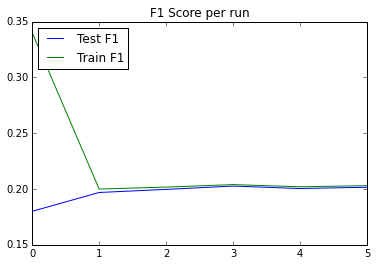

Validation Prediction for:
 F23- is 0.0818672301045
 F24-26 is 0.0812124786353
 F27-28 is 0.0822133520001
 F29-32 is 0.0824986527523
 F33-42 is 0.0840444286471
 F43+ is 0.0838977894469
 M22- is 0.0814446344
 M23-26 is 0.0841519328175
 M27-28 is 0.0833664699005
 M29-31 is 0.0841229676386
 M32-38 is 0.0856805446605
 M39+ is 0.0854995189966


In [24]:
print ("AdaBoost:")
clf = runTests(test_sizes, X_train,y_train,X_test,y_test,ensemble.AdaBoostClassifier())

prediction = runPredict(clf,X_test, display=False)
classes=clf.classes_
print("Validation Prediction for:")
for i in range(len(classes)):
    print " {} is {}".format(classes[i], prediction[i])


Logistic:
------------------------------------------
('Training set size: 50,', 'Train time (secs): 0.282')
('F1 score for training set: 0.32,', 'Prediction time (secs): 0.000')
('F1 score for test set: 0.14,', 'Prediction time (secs): 0.000')
------------------------------------------
('Training set size: 83456,', 'Train time (secs): 21.686')
('F1 score for training set: 0.183941238497,', 'Prediction time (secs): 0.019')
('F1 score for test set: 0.183977185583,', 'Prediction time (secs): 0.017')
------------------------------------------
('Training set size: 166912,', 'Train time (secs): 43.737')
('F1 score for training set: 0.182593222776,', 'Prediction time (secs): 0.048')
('F1 score for test set: 0.180381612435,', 'Prediction time (secs): 0.032')
------------------------------------------
('Training set size: 250369,', 'Train time (secs): 68.064')
('F1 score for training set: 0.18161593488,', 'Prediction time (secs): 0.064')
('F1 score for test set: 0.180676377126,', 'Prediction ti

'Train F1:[0.32000000000000001, 0.1839412384969325, 0.18259322277607362, 0.18161593488011696, 0.1824129409121546, 0.18250291769814586]'

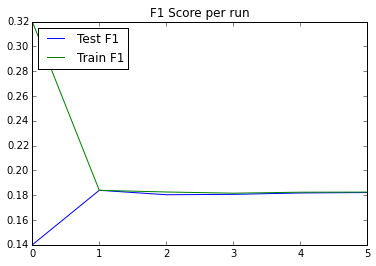

Validation Prediction for:
 F23- is 0.0563513778297
 F24-26 is 0.047380043485
 F27-28 is 0.0492584614494
 F29-32 is 0.0556129243341
 F33-42 is 0.092807065942
 F43+ is 0.0646000826775
 M22- is 0.0604948020212
 M23-26 is 0.108647874597
 M27-28 is 0.0785445586302
 M29-31 is 0.110090290462
 M32-38 is 0.143507225676
 M39+ is 0.132705292896


In [22]:
print ("Logistic:")
clf=runTests(test_sizes, X_train,y_train,X_test,y_test)

prediction = runPredict(clf,X_test, display=False)
classes=clf.classes_
print("Validation Prediction for:")
for i in range(len(classes)):
    print " {} is {}".format(classes[i], prediction[i])


In [23]:
prediction = runPredict(clf,X_test, display=False)
classes=clf.classes_
print("Validation Prediction for:")
for i in range(len(classes)):
    print " {} is {}".format(classes[i], prediction[i])


Validation Prediction for:
 F23- is 0.0338909434445
 F24-26 is 0.0319438937406
 F27-28 is 0.0317953315511
 F29-32 is 0.0391823125533
 F33-42 is 0.0536641036575
 F43+ is 0.035970076864
 M22- is 0.0636334905825
 M23-26 is 0.13075777854
 M27-28 is 0.105662344976
 M29-31 is 0.154613495938
 M32-38 is 0.193268754002
 M39+ is 0.125617474151


### EOF